In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/xn/p3zc10j52x39w1nb1bggp80w0000gn/T/ipykernel_34799/1083474609.py:6: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base.prepare(engine, reflect=True)


In [8]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())


['measurement', 'station']


In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(f"The most recent date in the data set is: {most_recent_date[0]}")

The most recent date in the data set is: 2017-08-23


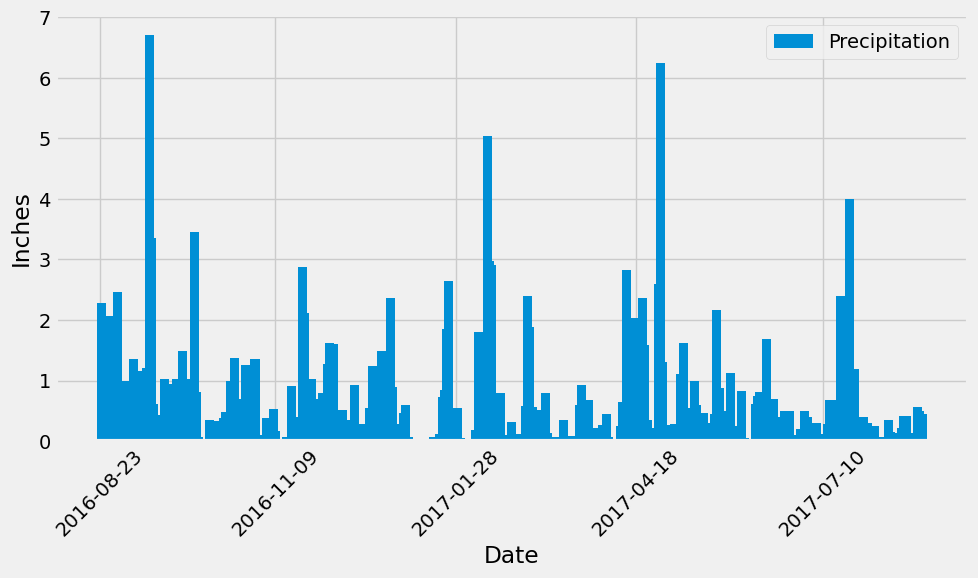

In [17]:
# Design a query to retrieve the last 12 months of precipitation data
# Starting from the most recent data point in the database

# Calculate the date one year from the last date in the dataset
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.pyplot as plt

# Use Pandas Plotting with Matplotlib to plot the data
# Convert 'Date' column to datetime type
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])

# Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], label='Precipitation', width=4)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



In [19]:
# Calculate summary statistics for the precipitation data
summary_stats = precipitation_df['Precipitation'].describe()

# Print the summary statistics
print(summary_stats)


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number of stations
total_stations = session.query(func.count(Station.station)).scalar()

print(f'The total number of stations in the dataset is: {total_stations}')


The total number of stations in the dataset is: 9


In [22]:
# Design a query to find the most active stations
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('station_count')).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Print the stations and their counts in descending order
for station in active_stations:
    print(f"Station: {station.station}, Count: {station.station_count}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [23]:
# Find the most active station
most_active_station = active_stations[0].station

# Design a query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs).label('min_temperature'),
                                 func.max(Measurement.tobs).label('max_temperature'),
                                 func.avg(Measurement.tobs).label('avg_temperature')).\
    filter(Measurement.station == most_active_station).all()

# Print the results
print(f"Most Active Station ID: {most_active_station}")
print(f"Lowest Temperature: {temperature_stats[0].min_temperature}°F")
print(f"Highest Temperature: {temperature_stats[0].max_temperature}°F")
print(f"Average Temperature: {temperature_stats[0].avg_temperature}°F")

Most Active Station ID: USC00519281
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66378066378067°F


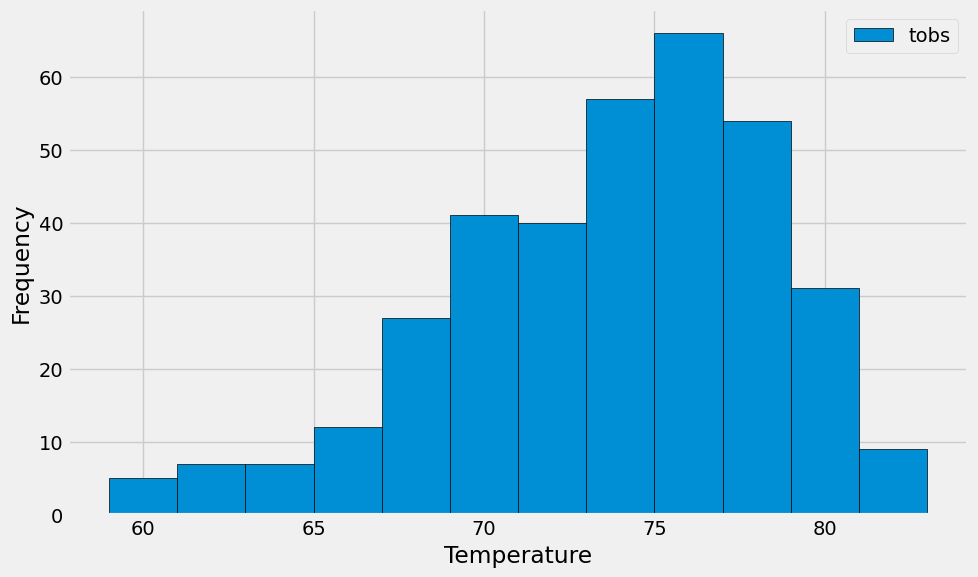

In [27]:
# Calculate the date one year from the last date in the dataset for the most active station
most_active_last_date = session.query(Measurement.date).\
    filter(Measurement.station == most_active_station).\
    order_by(Measurement.date.desc()).first()[0]

most_active_last_date = dt.datetime.strptime(most_active_last_date, '%Y-%m-%d')
most_active_one_year_ago = most_active_last_date - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
most_active_temperatures = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= most_active_one_year_ago).all()

# Save the query results as a Pandas DataFrame
most_active_temperatures_df = pd.DataFrame(most_active_temperatures, columns=['Date', 'Temperature'])

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(most_active_temperatures_df['Temperature'], bins=12, label='tobs', edgecolor='black')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


# Close Session

In [28]:
# Close Session
session.close()